# Advanced 6D-MAN Scenarios

In [1]:
import sys
import os
# Navigate relative to the current working directory
sys.path.append(os.path.abspath('../src'))
import numpy as np
import pandas as pd
from sixdman.core.network import Network
from sixdman.core.band import Band, OpticalParameters
from sixdman.core.planning import PlanningTool
from sixdman.core.visualize import analyse_result
import networkx as nx
import ast
from sixdman.utils.paths import get_project_root

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Use it to get paths
project_root = get_project_root()
results_dir = project_root / "results" / "MAN157" / "NoBypass"
results_dir.mkdir(parents=True, exist_ok=True)

## *1. Create Network Instance*

In [3]:
# Initialize network
network = Network(topology_name = 'MAN157')

# Load topology from .mat file
network.load_topology(filepath = '../data/MAN157Nodes.mat', matrixName ='MAN157Nodes')

# Set hierarchical levels
hl_dict = network.set_hierarchical_levels(
    HL1_standalone = [1, 5],
    HL2_standalone = [0, 2, 3, 4],
    HL3_standalone = list(range(6, 39)),
    HL4_standalone = list(range(39, 157))
)

## 2. *Define hierarchy node levels*

In [4]:
HL4_Standalone = hl_dict['HL4']['standalone']
HL4_colocated = hl_dict['HL4']['colocated']

HL3_Standalone = hl_dict['HL3']['standalone']
HL3_colocated = hl_dict['HL3']['colocated']

HL2_Standalone = hl_dict['HL2']['standalone']
HL2_colocated = hl_dict['HL2']['colocated']

HL1_Standalone = hl_dict['HL1']['standalone']

HL123_Standalone = HL1_Standalone + HL2_Standalone + HL3_Standalone
HL12_Standalone = HL1_Standalone + HL2_Standalone


## 3. Define Transmission Bands

In [5]:
# Define C-band parameters
c_band_params = OpticalParameters()

# Create C-band instance
c_band = Band(
    name='C',
    start_freq = 190.65, # THz
    end_freq = 196.675, # THz
    opt_params = c_band_params,
    network_instance = network,
    channel_spacing = 0.05 # THz
    )

# Define L-band parameters
l_band_params = OpticalParameters()

# Create L-band instance
l_band = Band(
    name='L',
    start_freq = 184.525, # THz
    end_freq = 190.565, # THz
    opt_params = l_band_params,
    network_instance = network,
    channel_spacing = 0.05 # THz
)

In [6]:
# define C-band and L-band frequency slots
spectrum_C = c_band.calc_spectrum()
spectrum_L = l_band.calc_spectrum()

# concatenate C-band and KL-band to a sigle frequency spectrum
spectrum = np.concatenate((spectrum_C, spectrum_L))

# define total number of frequency slots
num_fslots = 240

f_c_axis = spectrum * 1e12  # Convert to Hz
Pch_dBm = np.arange(-6, -0.9, 0.1)  # Channel power in dBm
num_Ch_mat = np.arange(1, len(spectrum) - 1)  # Channel indices

## 4. Create Planning Tool and Optimize Network

In [7]:
# Initialize planning tool
planner = PlanningTool(
    network_instance = network,
    bands = [c_band, l_band], 
    period_time = 10)


In [8]:
num_level_process = 4
minimum_hierarchy_level = 4
processing_level_list = [4, 3, 2]
splitter = []

In [9]:
G, subnetMatrix_HL = network.calculate_subgraph(4, minimum_hierarchy_level)

In [10]:
len(list(G.edges()))

166

In [11]:
G, subnetMatrix_HL = network.calculate_subgraph(3, minimum_hierarchy_level)

In [12]:
len(list(G.edges()))

47

In [13]:
for i in range(len(processing_level_list)):

    hierarchy_level = processing_level_list[i]
    # prev_hierarchy_level = processing_level_list[i - 1]

    print(f"Processing hierarchy level: {hierarchy_level}")

    match hierarchy_level:

        case 2:
            HL_Standalone = HL2_Standalone
            HL_colocated = HL2_colocated
            HL_lower_Standalone = HL4_Standalone + HL3_Standalone
            HL_up_Standalone = HL1_Standalone
            HL_all = np.concatenate((HL2_Standalone, HL2_colocated))
            capacity_updt_index = 0
            prev_hierarchy_level = 3
        case 3:
            HL_Standalone = HL3_Standalone
            HL_colocated = HL3_colocated
            HL_lower_Standalone = HL4_Standalone
            HL_up_Standalone = HL12_Standalone
            HL_all = np.concatenate((HL3_Standalone, HL3_colocated))
            capacity_updt_index = 1
            prev_hierarchy_level = 4
        case 4:
            HL_Standalone = HL4_Standalone
            HL_colocated = HL4_colocated
            HL_lower_Standalone = []
            HL_up_Standalone = HL123_Standalone
            HL_all = np.concatenate((HL4_Standalone, HL4_colocated))
            capacity_updt_index = 2
            prev_hierarchy_level = None

    sub_graph_HL, subnetMatrix_HL = network.calculate_subgraph(hierarchy_level, minimum_hierarchy_level)
    HL_connected_nodes = network.find_neighbors(HL_Standalone) - set(HL_lower_Standalone)
    splitter.append(len(list(sub_graph_HL.edges())))

    
    file_name = results_dir/  f"{network.topology_name}_HL{hierarchy_level}_K_path_attributes.csv"

    if os.path.exists(file_name):

        print(f"Loading K-path attributes of HL{hierarchy_level} ...")

        K_path_attributes_df = pd.read_csv(file_name)
        K_path_attributes_df['links'] = K_path_attributes_df['links'].apply(ast.literal_eval)
        K_path_attributes_df['nodes'] = K_path_attributes_df['nodes'].apply(ast.literal_eval)
    else:

        print(f"Calculating K-path attributes of HL{hierarchy_level} ...")

        k_paths = 100
        source_not_found = HL_Standalone.copy()
        while len(source_not_found) != 0:

            # define a list to store path attributes for this iteration
            K_path_attributes = []

            # iterate through each "source_not_found" node only
            for src in HL_Standalone:
                for dest in HL_connected_nodes:
                    K_path_attributes = network.calculate_paths(subnetMatrix_HL, K_path_attributes, source = src, target = dest, k = k_paths)

            # Convert K_path_attributes list to a temporary DataFrame
            K_path_attributes_df = pd.DataFrame(K_path_attributes)

            # Optionally save to CSV (if you want to track progress)
            K_path_attributes_df.to_csv(file_name, index=False)

            # Sort by num_hops and distance
            K_path_attributes_df_sorted = K_path_attributes_df.groupby(['src_node'], group_keys=False).apply(
                lambda x: x.sort_values(['num_hops', 'distance'])
            )

            # find disjoint pairs from the sorted full dataset
            pairs_disjoint = network.land_pair_finder(HL_Standalone, K_path_attributes_df_sorted, num_pairs=1)

            # Update source_not_found to exclude newly matched source nodes
            source_not_found = np.setdiff1d(HL_Standalone, pairs_disjoint['src_node'].unique())

            print('Remaining src nodes: ', source_not_found)

            k_paths += 20
    
    file_name = results_dir/ f"{network.topology_name}_HL{hierarchy_level}_K_path_attributes_colocated.csv"

    if os.path.exists(file_name):

        print(f"Loading K-path attributes of HL{hierarchy_level} colocated...")

        K_path_attributes_colocated_df = pd.read_csv(file_name)
        K_path_attributes_colocated_df['links'] = K_path_attributes_colocated_df['links'].apply(ast.literal_eval)
        K_path_attributes_colocated_df['nodes'] = K_path_attributes_colocated_df['nodes'].apply(ast.literal_eval)
    else:

        print(f"Calculating K-path attributes of HL{hierarchy_level} colocated...")
        
        k_paths = 20

        # define a list to store path attributes
        K_path_attributes_colocated = []

        # iterate through each standalone HL4 node
        for src in HL_colocated:
            
            if (hierarchy_level == 3) and (src in HL2_Standalone):
                HL_connected_nodes_col = HL_connected_nodes - set(HL1_Standalone)
            else:
                HL_connected_nodes_col = HL_connected_nodes.copy()

            for dest in HL_connected_nodes:
                if src != dest:
                    K_path_attributes_colocated = network.calculate_paths(subnetMatrix_HL, K_path_attributes_colocated, source = src, target = dest, k = k_paths)

        # Convert K_path_attributes list to dataframe
        K_path_attributes_colocated_df = pd.DataFrame(K_path_attributes_colocated)

        # save dataframe to csv file
        K_path_attributes_colocated_df.to_csv(file_name, index = False)

    
    # sort dataframes based on num_hops and distance (in order)
    K_path_attributes_df_sorted = K_path_attributes_df.groupby(['src_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))
    K_path_attributes_colocated_df_sorted = K_path_attributes_colocated_df.groupby(['src_node', 'dest_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))

    # find disjoint pairs for standalone nodes
    pairs_disjoint = network.land_pair_finder(HL_Standalone, K_path_attributes_df_sorted, num_pairs = 1)

    print(f"process link GSMR of HL{hierarchy_level} ...")

    GSNR_opt_link, _, _, _ = c_band.process_link_gsnr(f_c_axis = f_c_axis, 
                                                  Pch_dBm = Pch_dBm, 
                                                  num_Ch_mat = num_Ch_mat,
                                                  spectrum_C = spectrum_C,
                                                  Nspan_array = np.ones(network.all_links.shape[0], dtype=int),
                                                  hierarchy_level = hierarchy_level, 
                                                  minimum_hierarchy_level = minimum_hierarchy_level, 
                                                  result_directory = results_dir)
    
    planner.initialize_planner(num_fslots = num_fslots, 
                               hierarchy_level = hierarchy_level,
                               minimum_hierarchy_level = minimum_hierarchy_level)
    
    if hierarchy_level == minimum_hierarchy_level:

        # generate port capacity for HL4 nodes uisng Monte Carlo simulation
        planner.simulate_traffic_initial(num_nodes = len(HL_all),
                                         monteCarlo_steps = 100,
                                         min_rate = 20, # Gbps
                                         max_rate = 200, # Gbps
                                         seed = 50, 
                                         result_directory = results_dir)

        # Traffic growth simulation over 10 years
        planner.simulate_traffic_annual(lowest_hierarchy_dict = hl_dict[f"HL{hierarchy_level}"], 
                                        CAGR = 0.4, 
                                        result_directory = results_dir)
        
    print(f"running planner for HL{hierarchy_level} ...")

    # run the planner for the current hierarchy level    
    planner.run_planner(HL_dict = hl_dict[f"HL{hierarchy_level}"],
                pairs_disjoint = pairs_disjoint,
                kpair_standalone = 1,
                kpair_colocated = 1,
                candidate_paths_standalone_df = K_path_attributes_df,
                candidate_paths_colocated_df = K_path_attributes_colocated_df_sorted,
                GSNR_opt_link = GSNR_opt_link,
                prev_hierarchy_level = prev_hierarchy_level,
                hierarchy_level = hierarchy_level,
                minimum_level = minimum_hierarchy_level,
                node_cap_update_idx = capacity_updt_index, 
                result_directory = results_dir)


Processing hierarchy level: 4
Loading K-path attributes of HL4 ...
Loading K-path attributes of HL4 colocated...
process link GSMR of HL4 ...
Loading precomputed link GSNR analysis
Loading precomputed HL_capacity_final ...
Loading precomputed Traffic Matrix ...
running planner for HL4 ...
FS_path [0]
FS_path [0]
FS_path [1]
FS_path [1]
FS_path [2]
FS_path [2]
FS_path [3]
FS_path [3]
FS_path [0]
FS_path [4]
FS_path [4]
FS_path [5]
FS_path [5]
FS_path [6]
FS_path [0]
FS_path [0]
FS_path [1]
FS_path [1]
FS_path [2]
FS_path [2]
FS_path [3]
FS_path [3]
FS_path [4]
FS_path [4]
FS_path [5]
FS_path [5]
FS_path [0]
FS_path [6]
FS_path [7]
FS_path [1]
FS_path [2]
FS_path [8]
FS_path [0]
FS_path [9]
FS_path [1]
FS_path [10]
FS_path [0]
FS_path [0]
FS_path [1]
FS_path [1]
FS_path [2]
FS_path [2]
FS_path [3]
FS_path [3]
FS_path [0]
FS_path [0]
FS_path [1]
FS_path [1]
FS_path [2]
FS_path [2]
FS_path [3]
FS_path [3]
FS_path [4]
FS_path [4]
FS_path [5]
FS_path [0]
FS_path [5]
FS_path [6]
FS_path [1]
F

In [14]:
planner.lowest_HL_added_traffic_annual_standalone[0, :]

array([ 59.96709057, 142.82429044, 178.05013447, 163.40910739,
        97.7604046 , 185.21807945, 160.73006199, 150.6350501 ,
        42.47384483, 184.93552088,  89.78797887,  73.08731819,
       131.01165465, 104.21232122,  65.96100458, 171.01925997,
        52.15145642,  60.88055073, 138.77776029, 106.24092411,
        33.22052162,  45.01281283,  40.21529305, 106.00129378,
       117.25332127, 192.45278884, 125.08261606, 114.7995364 ,
       186.00728399, 185.46626296,  65.36159566, 142.87386993,
       193.56970135,  60.85309646, 148.88309574, 163.59681935,
       188.61521594, 173.67004924,  95.87824521,  20.97917639,
        26.27575918,  22.50296582, 126.00378748,  88.93875733,
        40.66741094, 175.6017216 , 167.89826563, 152.74850328,
       171.26195063,  92.27523862, 154.75160023, 120.73330014,
       130.38276331,  73.65829726, 128.42825123,  96.62183113,
       116.93798927, 107.61137429, 109.98049486, 185.14270686,
        67.31786391,  28.94558351, 103.2845653 ,  93.47

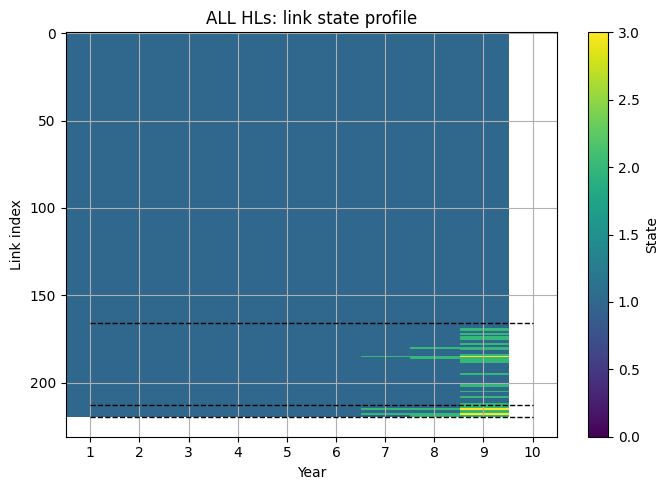

In [15]:
analysing = analyse_result(network, planner, processing_level_list, results_dir)
analysing.plot_link_state(splitter, 
                          save_flag = 1,
                          save_suffix = "_NoBypass")

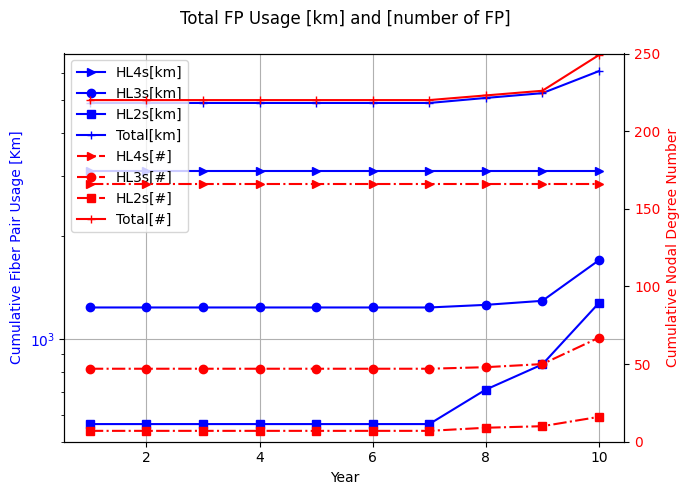

In [16]:
analysing.plot_FP_usage(save_flag = 1, 
                        save_suffix = "_NoBypass")

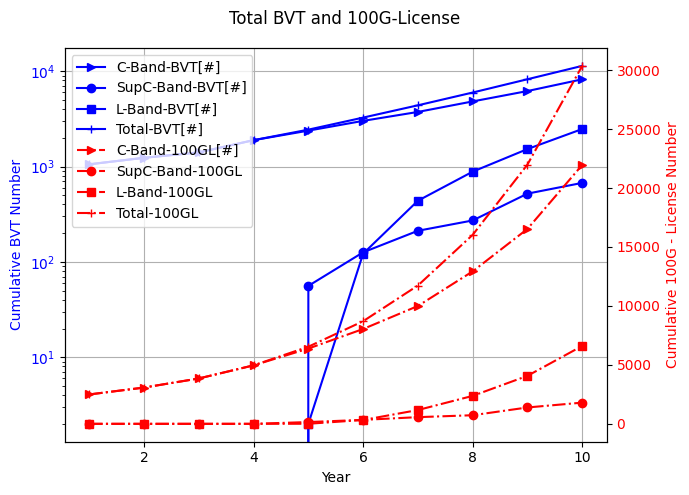

In [17]:
analysing.plot_bvt_license(save_flag = 1, 
                           save_suffix = "_NoBypass")

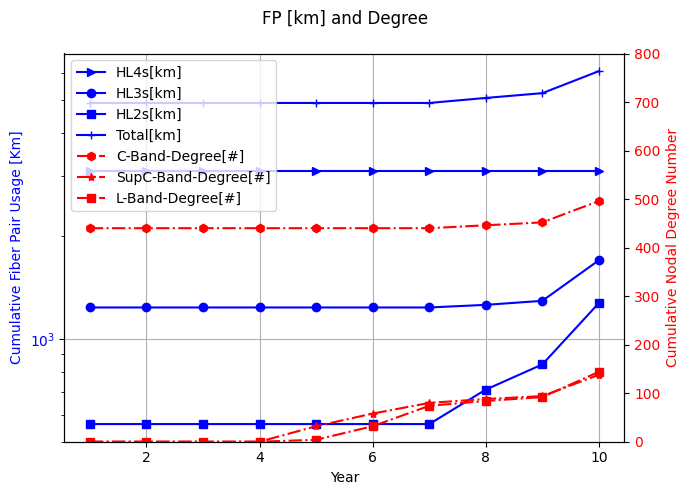

In [18]:
analysing.plot_FP_degree(save_flag = 1, 
                        save_suffix = "_NoBypass")

In [19]:
analysing.calc_cost(save_flag = 1, 
                    save_suffix = "_NoBypass")

,OPEX,Capex_RoB,Capex_MCS,Capex_100GL,CAPEX
0,2450.22,836.000000,46.200000,2492.000000,3374.200000
1,2450.22,0.000000,7.875000,3076.000000,3083.875000
2,2450.22,0.000000,7.525000,3848.000000,3855.525000
3,2450.22,0.000000,21.175000,4960.000000,4981.175000
4,2450.22,4.487724,24.130004,6549.496241,6578.113968
5,2450.22,8.279851,36.770767,8756.435512,8801.486130
6,2450.22,9.632900,50.852450,11871.006844,11931.492194
7,2534.79,13.690086,71.267896,16263.368529,16348.326510
8,2617.77,13.019418,101.646686,22357.098075,22471.764179
9,3036.47,93.404838,140.333312,30883.340479,31117.078628


In [20]:
analysing.calc_latency(primary_paths = planner.primary_path_storage,
                       processing_level_list = processing_level_list)

array([1011.25,  961.25,  757.5 ,  911.25,  640.  ,  655.  ,  627.5 ,
        622.5 ,  645.  ,  685.  , 1011.25, 1011.25,  681.  ,  678.5 ,
        961.25,  675.  ,  730.  ,  685.  , 1387.95, 1255.45, 1205.45,
       1155.45, 1315.45, 1255.45, 1275.45, 1311.45, 1255.45, 1205.45,
       1252.95, 1308.95, 1360.45, 1315.45, 1305.45, 1270.45, 1257.95,
       1285.45,  707.5 ,  735.  ,  720.  ,  702.5 ,  725.  ,  765.  ,
        755.  ,  765.  ,  810.  ,  761.  ,  880.  ,  830.  ,  758.5 ,
        880.  ,  880.  ,  830.  ,  780.  ,  837.5 ,  945.7 ,  716.55,
       1036.2 ,  691.55,  925.7 ,  905.7 ,  880.7 ,  855.7 ,  900.7 ,
       1111.2 , 1176.2 , 1141.2 ,  996.2 , 1106.2 , 1262.9 , 1036.2 ,
       1117.9 , 1077.9 , 1157.9 , 1137.9 , 1147.9 , 1142.9 , 1260.45,
       1075.45, 1285.45, 1625.45,  961.55, 1600.45, 1280.45, 1305.45,
       1465.45,  926.85,  981.85,  966.85, 1000.45,  650.  ,  695.  ,
        675.  ,  710.  ,  715.  ,  746.55,  706.55,  700.  ,  710.  ,
        680.  ,  655